# INVENTORY MANAGEMENT (Inventory Segmentation/Clustering)
## 

Hello everyone, My name is Rohit Kumar and I am a freelance Data Engineer. In this project, my aim is to conduct an unsupervised clustering analysis on SKU(Stock Keeping Unit) dataset 
 sourced from a logistics company called Trialto Latvia LTD firm's database(Imaginary). The company has been facing a lot of challenges to Maintain and manage their inventory and products thats why they hired me. lets see what are the problems they have  and solution we can provide in this matter:-
 
 ### Problems/Requirements
 * Company requires to segment their inventory into 4 categories initally from Lowest to highest orders to manage stocks. Unfortunately they dont have an analyst to do so.
* The company is new and growing struggle to determine which products are in high demand and which ones are slow-moving, leading to inefficient stocking.
* Manage inventory based on handling characteristics like expiration date or weight becomes challenge.
* Struggle to keep the right amount of each product in stock, leading to wasted space or running out of popular items.

### Solution(Clustering)

* Clustering helps separate products into different groups: ones that sell quickly to ones that sell slowly and ones which are in middle.
* Group products with similar handling needs together, making inventory management easier.
* Helps decide how much of each product to keep in stock based on how quickly they sell.
* Helps businesses manage their inventory better, saving money and making operations run more smoothly.

## TABLE OF CONTENTS
1. [**DATASET**](#dataset)
2. [**IMPORTING LIBRARIES**](#importing-libraries)
3. [**LOADING DATA**](#loading-data)
4. [**DATA CLEANING & PREPROCESSING**](#data-cleaning-preprocessing)
5. [**SCALING**](#scaling)
6. [**CLUSTERING PRE-PCA**](#clustering)
7. [**DIMENTIONALITY REDUCTION USING PCA**](#PCA)
8. [**CLUSTERING POST PCA**](#clustering-pca)
9. [**EVALUATING MODEL**](#evaluating-models)
10. [**CONCLUSION**](#conclusion)
11. [**SOURCE**](#source)


## 01. DATASET

* Stock keeping units. (2019). [UCI Machine Learning](https://doi.org/10.24432/C5CG7S)
* This dataset is licensed under a [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/legalcode) (CC BY 4.0) license.
* The dataset comes from Trialto Latvia LTD, a logistics company.
* Contains 2279 observations with 7 numerical features.
    - Unit price (in euro), 
    - Expire date (shelf-life), 
    - Total outbound (number of pallets sold from 2017-02-06 to 2018-02-13), 
    - Number of outbound orders (how many times a product was ordered from 2017-02-06 to 2018-02-13), 
    - Pallet weight (weight of a fully-loaded pallet in kg), 
    - Pallet height (height of a fully-loaded pallet in cm), 
    - Units per pallet.


## 02. IMPORTING LIBRARIES 


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from yellowbrick.cluster import KElbowVisualizer  #pip install yellowbrick

## 03. LOADING DATA

In [2]:
# Load the dataset
data = pd.read_excel("dataset/sku_data.xlsx")

# Display the first few rows of the dataset to understand its structure
print("Total Datapoints & Features: ",data.shape)
data.head()

Total Datapoints & Features:  (2279, 8)


,ID,Unitprice,Expire date,Outbound number,Total outbound,Pal grossweight,Pal height,Units per pal
0,1,0.058,547,9,2441.0,105.60,1.56,1920
1,2,0.954,547,0,0.0,207.68,1.00,384
2,3,2.385,547,12,23.0,165.78,1.02,108
3,4,5.100,547,0,0.0,221.04,1.05,72
4,5,0.000,547,0,0.0,0.00,0.00,0


## 04 DATA CLEANING & PREPROCESSING

In this section we will clean the dataset as it is not perfect enough for further analysis.



In [3]:
data.describe()

,ID,Unitprice,Expire date,Outbound number,Total outbound,Pal grossweight,Pal height,Units per pal
count,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000,2279.000000
mean,1140.000000,4.269402,410.371654,235.976305,731.701053,192.939582,0.672798,755.563405
std,658.034953,14.449000,240.875419,700.230685,2146.029848,164.616813,0.552117,6278.437915
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,570.500000,0.000000,365.000000,0.000000,0.000000,60.000000,0.000000,32.000000
50%,1140.000000,1.293800,547.000000,1.000000,3.000000,167.680000,0.840000,108.000000
75%,1709.500000,4.545000,547.000000,45.000000,419.500000,277.560000,1.020000,384.000000
max,2279.000000,518.592000,734.000000,6325.000000,26411.000000,907.200000,2.160000,200000.000000


In [4]:
# Check for NaN values
data.isna().sum()

ID                 0
Unitprice          0
Expire date        0
Outbound number    0
Total outbound     0
Pal grossweight    0
Pal height         0
Units per pal      0
dtype: int64

In [5]:
# Check for zeroes in each column
(data == 0).sum()

ID                   0
Unitprice          710
Expire date        529
Outbound number    979
Total outbound     979
Pal grossweight    371
Pal height         787
Units per pal      295
dtype: int64

 The above description of the data clearly shows that there are some problems with it:
 * There is no requirement for products with unitprice zero.
 * The several features have some zeroes.
 * The column's naming convention is not suitable.

In [6]:
# Rename the columns by replacing the spaces in between with underscore and lowercasing for further ease of access
data = data.rename(columns=lambda x: x.strip().lower().replace(' ', '_'))

In [7]:
# Dropping rows with unitprice = 0
data = data.loc[(data['unitprice'] != 0)]
data

,id,unitprice,expire_date,outbound_number,total_outbound,pal_grossweight,pal_height,units_per_pal
0,1,0.058,547,9,2441.0,105.600,1.56,1920
1,2,0.954,547,0,0.0,207.680,1.00,384
2,3,2.385,547,12,23.0,165.780,1.02,108
3,4,5.100,547,0,0.0,221.040,1.05,72
5,6,1.110,547,1,1.0,207.680,1.00,384
...,...,...,...,...,...,...,...,...
2215,2216,5.905,0,7,19.0,240.000,0.00,400
2237,2238,1.038,0,132,1306.0,60.000,0.00,1200
2239,2240,0.920,730,19,140.0,88.704,0.00,144
2243,2244,2.020,730,354,710.0,322.560,0.00,288


In [8]:
# lets Check Again if we still have zeroes in other columns after removing Unitprice with zero
(data == 0).sum()

id                   0
unitprice            0
expire_date        168
outbound_number    481
total_outbound     481
pal_grossweight    118
pal_height         257
units_per_pal       87
dtype: int64

In [9]:
data = data.loc[(data['expire_date'] != 0)]
data = data.loc[(data['outbound_number'] != 0)]
data = data.loc[(data['pal_height'] != 0)]
data = data.loc[(data['pal_grossweight'] != 0)]

In [10]:
# The data is finally clean and preprocessed having only non zero values
(data == 0).sum()

id                 0
unitprice          0
expire_date        0
outbound_number    0
total_outbound     0
pal_grossweight    0
pal_height         0
units_per_pal      0
dtype: int64

In [11]:
# 'id' is a unique column in our dataset hence using it as index for dataframe
data.set_index('id', inplace=True)
data.head()

,unitprice,expire_date,outbound_number,total_outbound,pal_grossweight,pal_height,units_per_pal
id,,,,,,,
1,0.058,547,9,2441.0,105.60,1.56,1920
3,2.385,547,12,23.0,165.78,1.02,108
6,1.110,547,1,1.0,207.68,1.00,384
7,2.515,547,2,4.0,165.78,1.02,108
12,1.042,547,6,14.0,207.68,1.00,384


In [12]:
data.describe()

,unitprice,expire_date,outbound_number,total_outbound,pal_grossweight,pal_height,units_per_pal
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000
mean,5.169042,541.919868,575.461032,1599.712075,261.891513,1.071059,326.518112
std,5.852186,92.179597,1016.361754,3120.180085,138.793198,0.275041,526.938336
min,0.003600,365.000000,1.000000,1.000000,10.160000,0.060000,12.000000
25%,1.119500,547.000000,3.000000,7.000000,167.680000,1.000000,72.000000
50%,2.653000,547.000000,91.000000,397.000000,226.800000,1.020000,108.000000
75%,5.618500,547.000000,713.500000,1825.500000,320.670000,1.050000,384.000000
max,26.540000,730.000000,6325.000000,26411.000000,907.200000,1.800000,2160.000000


## 05. SCALING DATA

The data is scaled to remove any unscaling between features as we see in preprocessing section that the data has a lot of different scaling units such as pal_grossweight in kg and pal_height in cm. Similarly other features can have scalling issues which can affect our result during clustering


In [13]:
numeric_data = data
#Scaling
scaler = StandardScaler()
scaler.fit(numeric_data)
scaled_ds = pd.DataFrame(scaler.transform(numeric_data),columns= numeric_data.columns )
print("All features are now scaled")

All features are now scaled


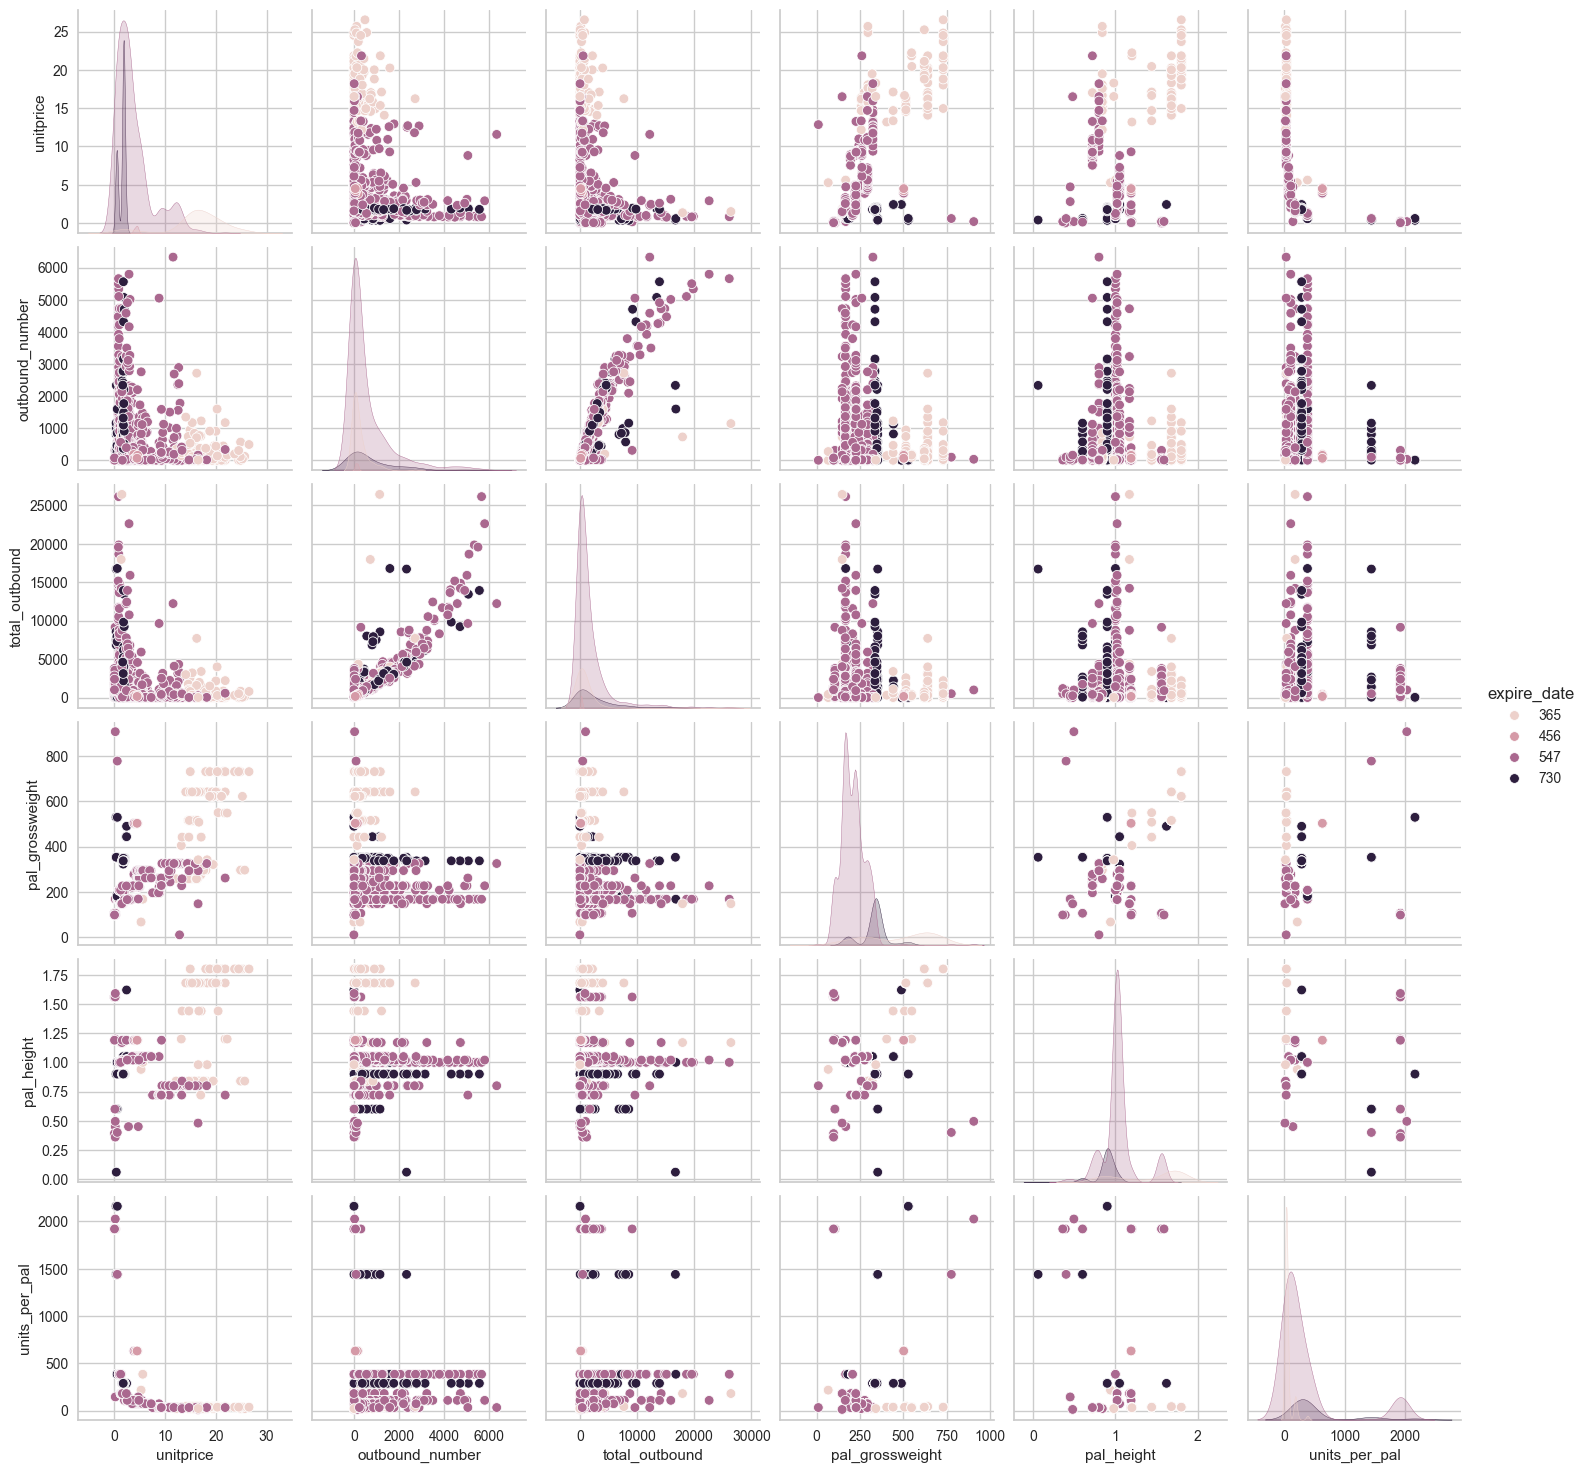

In [14]:
# A pairplot to see how features look
sns.pairplot(numeric_data, hue="expire_date")
plt.show()

## 06. CLUSTERING PRE-PCA

 In the project we will use 2 different clustering Techniques:
* DBSCAN CLUSTERING -  The reason to choose DBSCAN is that it can identify outliers as noise points, which do not belong to any cluster. Since we are expecting our dataset to have  few noisy data or outliers, DBSCAN can be beneficial for identifying or excluding them from the clusters.

* K-MEANS CLUSTERING - The reason to choose this technique is because we have a prior knowledge or assumption about the number of clusters in our data, the company requires the minimum cluster to be minimum 4. K-means might be a suitable choice as it requires specifying the number of clusters beforehand.

At the end we will see which technique describes our clustered data very well and will move ahead with it.

### DBSCAN

First lets run various epsilon and min_samples values to get best value of k and find best silhouette score


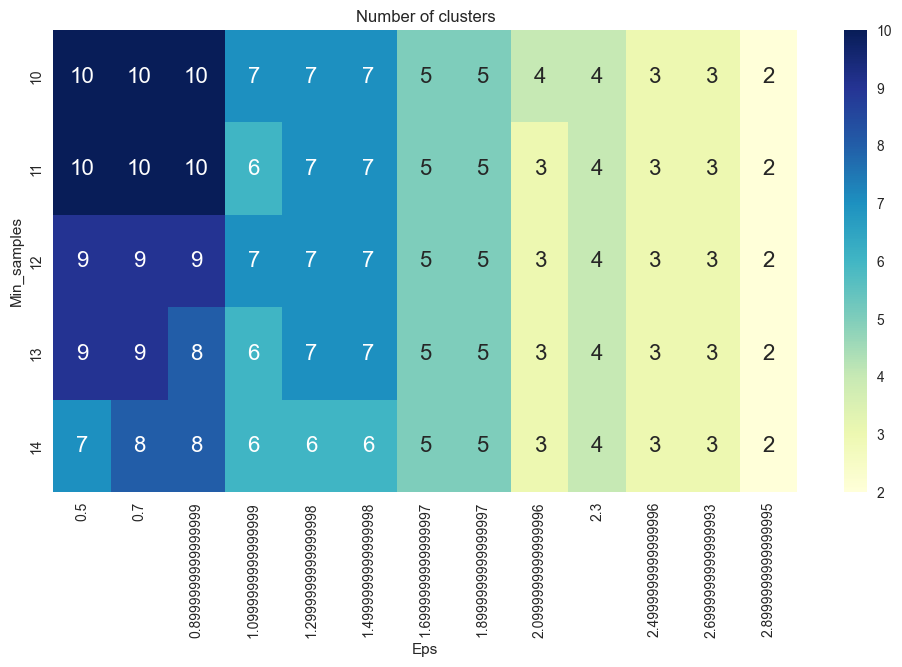

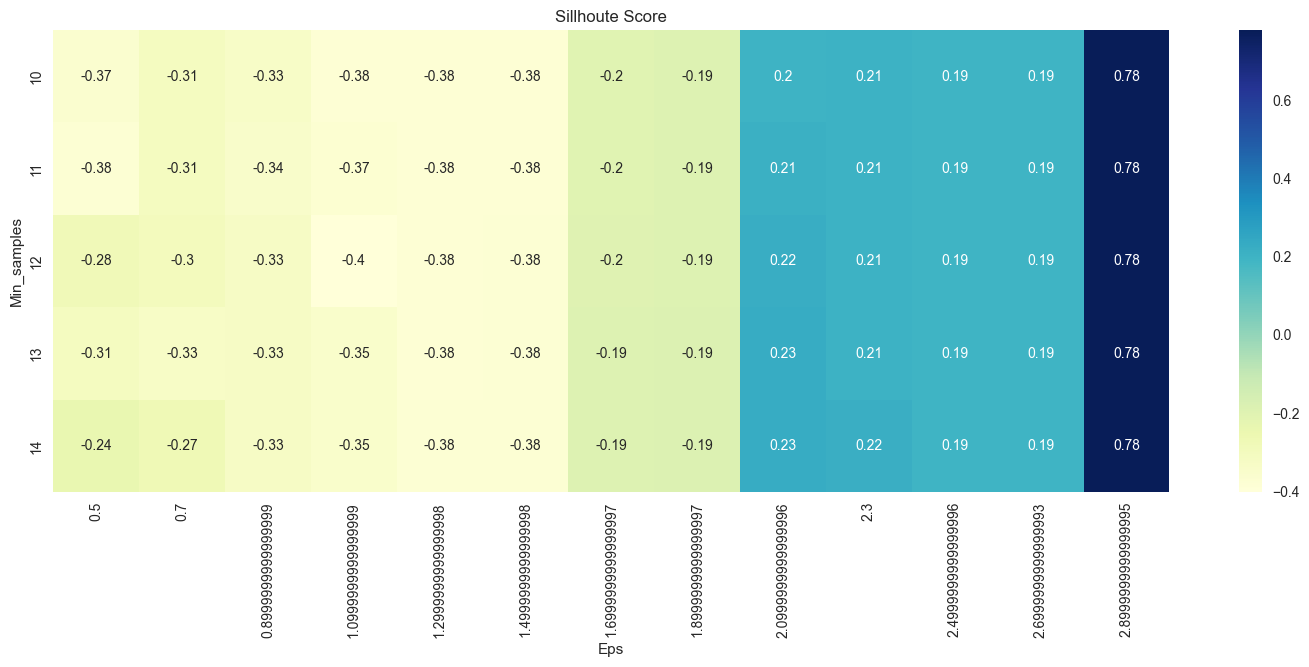

In [15]:


eps_values = np.arange(0.5,3,0.2) # eps values to be investigated
min_samples = np.arange(10,15) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(scaled_ds)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(data, DBS_clustering.labels_))

# Creating temporary DFs to save Eps and Min samples value along with no. of clusters
temp_df = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
temp_df['No_of_clusters'] = no_of_clusters
temp_df2 = pd.pivot_table(temp_df, values='No_of_clusters', index='Min_samples', columns='Eps')

# plot Heatmap for number of cluster with various epsilon min_sample values
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(temp_df2, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

# Creating temporary DFs to save Eps and Min samples value along with silouette scores
temp_df = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
temp_df['Sil_score'] = sil_score
temp_df2 = pd.pivot_table(temp_df, values='Sil_score', index='Min_samples', columns='Eps')

# plot Heatmap for silouette scores with various epsilon min_sample values
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(temp_df2, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
ax.set_title('Sillhoute Score')
plt.show()

The above cluster Heatmap and Silhoutte Score heatmap shows various number of clusters and silhoutte scores based on different values of Epsilon and minimum samples in DBSCAN clustering
* Total range of possible clusters is 2 to 10.
* The best silhoutte score is 0.78 with 2 clusters having epsilon =2.89 and minimum sample between 10-15. However, we will not be using these values for further analysis.
* The company requires initially to be able to divide their inventory into 4 parts(see requirements), so we will take k=4 i.e. divide it into 4 clusters.
* Hence to achieve k=4 we can use silhoutte score = -0.19 with epsilon = 1.8 and minimum samples = 15 to for further analysis.

Lets Run the DBSCAN algorithm now with above values

cluster
 1    598
 2    126
 3     84
 0     66
-1     37
Name: count, dtype: int64


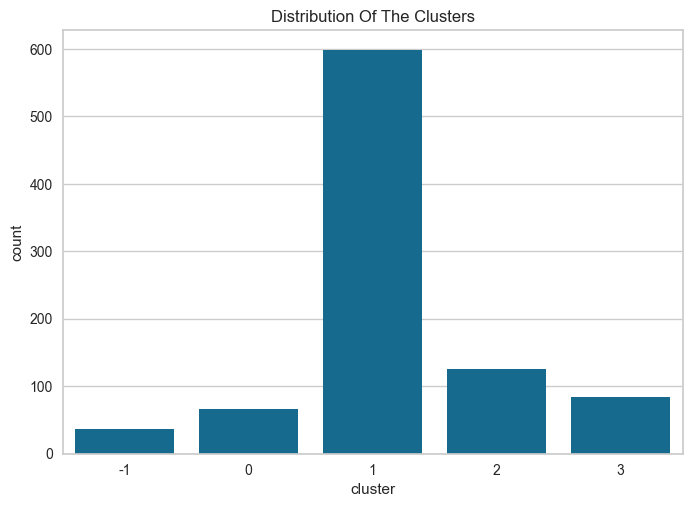

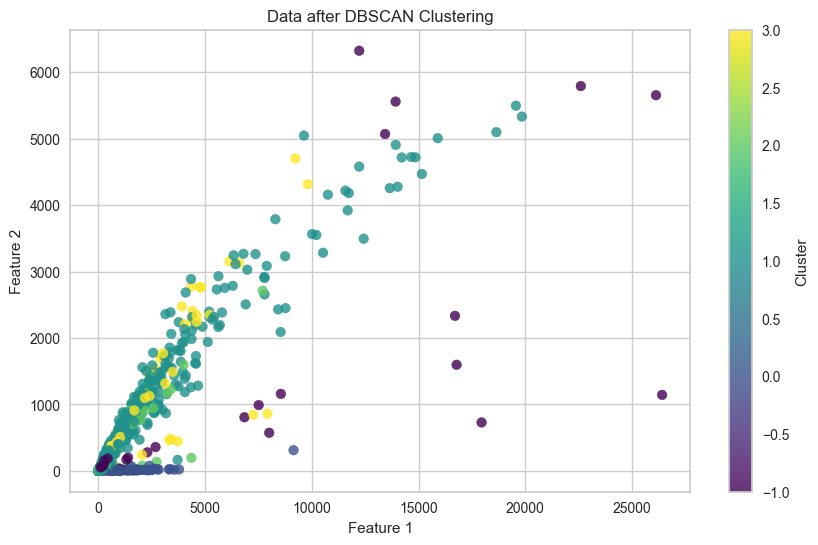

In [16]:
# Specify the epsilon (eps) and minimum samples (min_samples) for DBSCAN
eps = 1.8
min_samples =15

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples,algorithm="auto")
dbscan.fit(scaled_ds)

# Add cluster labels to the dataset
data["cluster"] = dbscan.labels_

# print Label/Cluster counts
print(data['cluster'].value_counts())

# Visualize the distribution of Clusters
pl = sns.countplot(x=data["cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()


# Visualize the data after DBSCAN clustering
plt.figure(figsize=(10, 6))
plt.scatter(data['total_outbound'], data['outbound_number'], c=dbscan.labels_, cmap='viridis', alpha=0.8)
plt.title('Data after DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

* We can see above that the distribution of cluster is not proportional.

Lets do the K-Means clustering in the next section.

### K-MEANS

* Before calculating K - Means. Lets calculate Silhoute score for K- Means and we will later compare it with DBSCAN score.

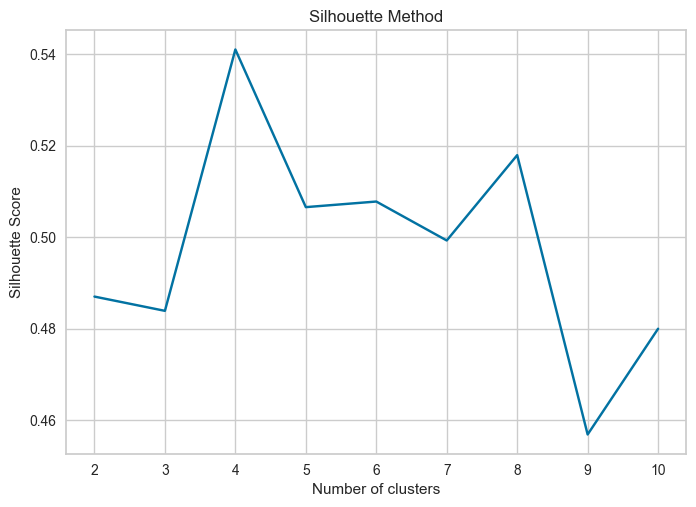

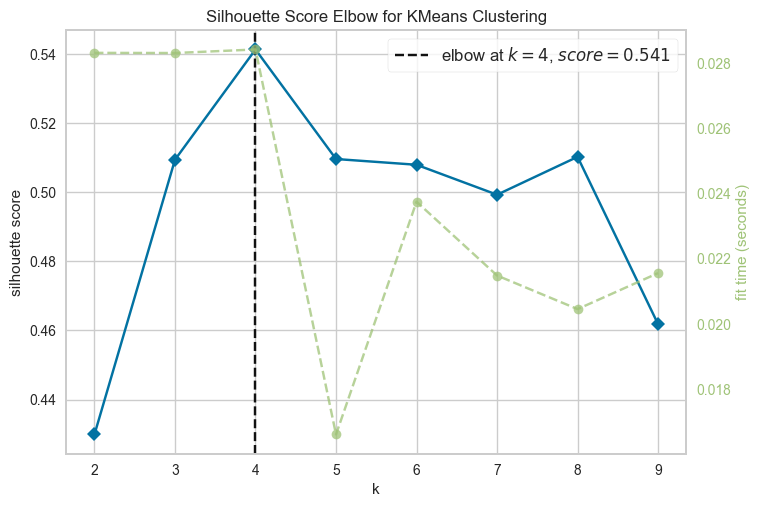

In [17]:
# Calculate silhouette score for different k
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_ds)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_ds, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Method to calcluate silhouette score
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
silhouette_scores

# Plot the Elbow Method to calculate silhouette score
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(scaled_ds)
visualizer.show()
plt.show()

* We can see that in first figure our silhouette score is highest at k=4 and relatively better if we use k between 4 to 7.
* We can also compare our score with [Elbow method](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) and we see that k=4 gives you the best silhouette score of 0.541

Lets perform the K- means with k=4 and see how it looks like

cluster
3    666
0     98
1     85
2     62
Name: count, dtype: int64


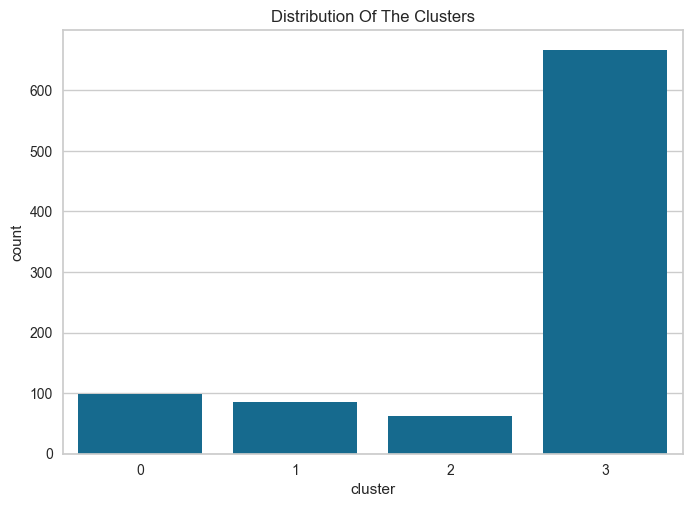

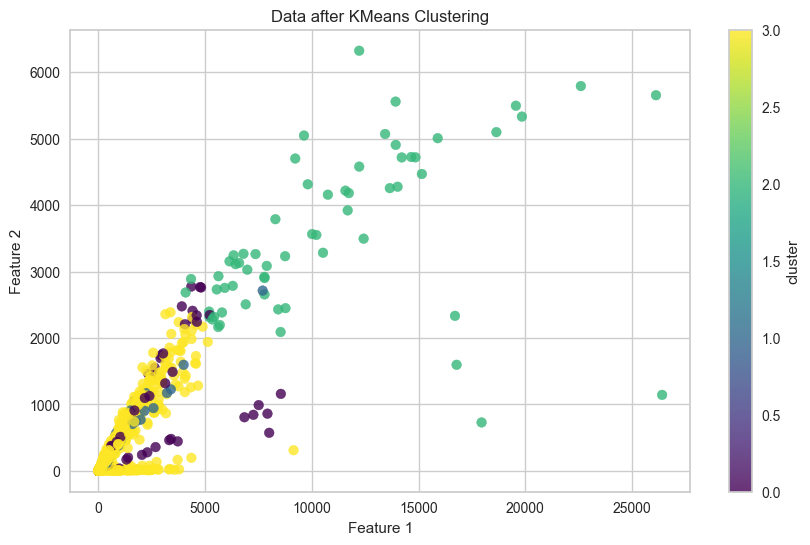

In [18]:
# Choose number of clusters (e.g., based on business knowledge or elbow method)
n_clusters = 4

# Fit KMeans clustering
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(scaled_ds)

# Add cluster labels to the dataset
data["cluster"] = kmeans.labels_

# print Label/Cluster counts
print(data['cluster'].value_counts())


# Visualize the distribution of CLusters
pl = sns.countplot(x=data["cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()


# Visualize the data after KMeans clustering
plt.figure(figsize=(10, 6))
plt.scatter(data['total_outbound'], data['outbound_number'], c=kmeans.labels_, cmap='viridis', alpha=0.8)
plt.title('Data after KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='cluster')
plt.show()


In K-Means the proportion of cluster is somewhat better than DBSCAN


Lets compare the results:-

DBSCAN:
* In DBSCAN best number of cluster or k is 2 based on silhouette score which is not a good value as we can see the data is much more complex to have only 2 clusters.
* With K=4, the clustering is not proportional enough. It has lesser number of datapoints for each clusters compared to K-Means.

K-Means:
* Silhouette score and elbow method gives relatively better K value which is 4 compared to DBSCAN.
* Distribution of clusters shows far better proportionality as compared to DBSCAN.

With above comparisons and visualizations its pretty clear that K-Means is far better choice for clustering. Hence we will move ahead with it.








## 07. DIMENTIONALITY REDUCTION USING PCA (PRINCIPAL COMPONENT ANALYSIS)


Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

Note:
* Even though we have found best clustering technique and value of K, We still need to visualise the clusters but its really hard to do it since we have 7 features in our dataset. In order to work with it we will use PCA ahead.


In [19]:
# Step 3: Dimensionality reduction using PCA

pca = PCA()
data_pca = pca.fit_transform(scaled_ds)
pca.explained_variance_ratio_*100


array([38.17930869, 25.08642397, 18.59730413,  9.5518825 ,  5.24544316,
        1.8047221 ,  1.53491546])

Above, we can see the distribution of each Principal Component
* I am reducing number of principal component(Dimensions) = 4 because with first 4 components we can preserve more than 90 of Variance of original data.

Lets do the PCA for n_component=4

[38.17930869 25.08642397 18.59730413  9.5518825 ]


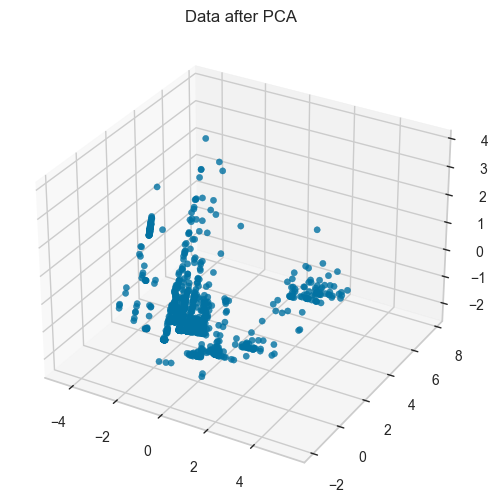

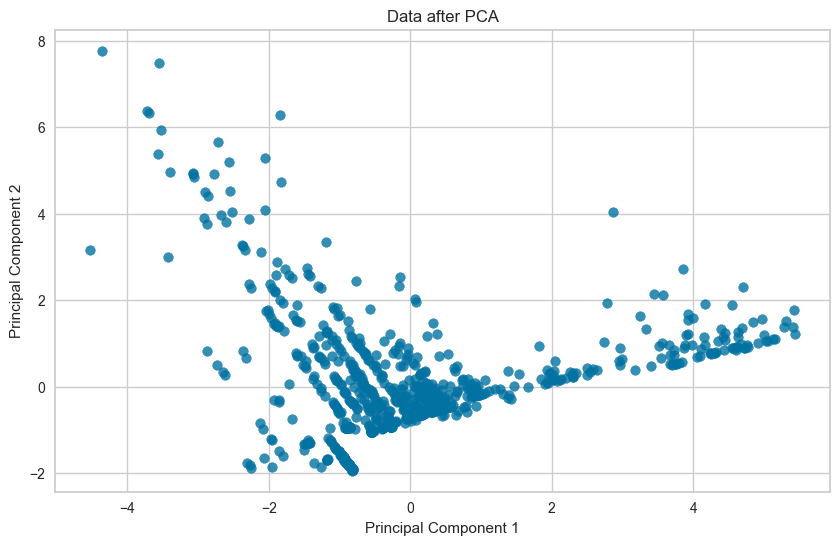

In [20]:
# Dimensionality reduction using PCA with n_component=4
pca = PCA(n_components=4)
x_pca = pca.fit_transform(scaled_ds)

print(pca.explained_variance_ratio_*100)

# Visualize first 3 Components after PCA in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_pca[:,0],x_pca[:, 1], x_pca[:, 2], alpha=0.8)
ax.set_title('Data after PCA')
plt.show()

# Visualize the first 2 components after PCA
plt.figure(figsize=(10, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], alpha=0.8)
plt.title('Data after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## 08. CLUSTERING POST PCA (K-MEANS)

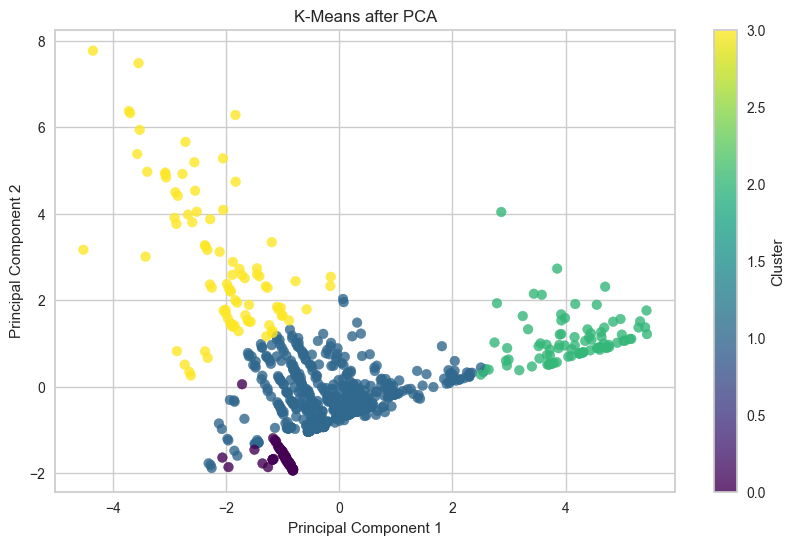

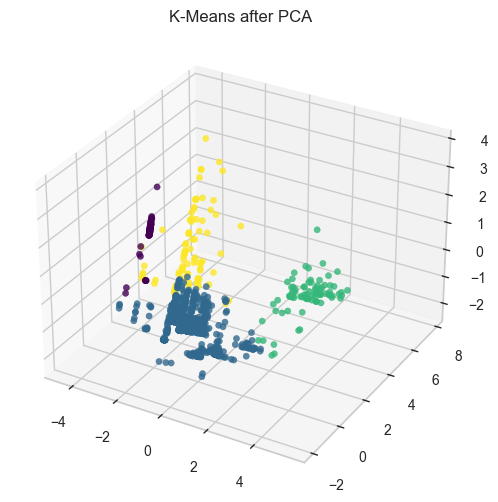

In [21]:
# Step 4: Perform KMeans clustering on the transformed data
kmeans_transformed = KMeans(n_clusters=n_clusters, random_state=42)
transformed_clusters = kmeans_transformed.fit_predict(x_pca)
data["cluster"] = transformed_clusters

# print(transformed_clusters)

# Visualize the data after KMeans clustering on transformed data
plt.figure(figsize=(10, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=data["cluster"], cmap='viridis', alpha=0.8)
plt.title('K-Means after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Visualize the data after PCA
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_pca[:,0],x_pca[:, 1], x_pca[:, 2], c=data["cluster"], cmap='viridis', alpha=0.8)
ax.set_title('K-Means after PCA')
plt.show()

Finally using the PCA is indeed a right decision resulted in lowering the features dimension reducing and keeping almost 90% of variance intact with number of component as 4. As a result we can see the clusters more clearly and accurately into the above 3D visualization.

## 09. EVALUATING MODEL 


Now that we have clustered our data, Lets do some analysis and find some insights to help the company manage their inventory better.

### Unit Price vs Total Outbound Orders vs Cluster

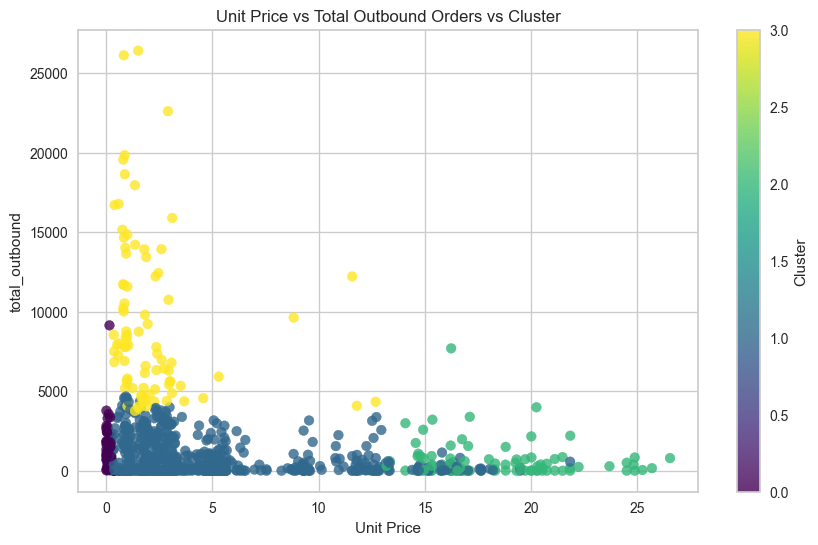

In [22]:
# using scatter plot to compare Unitprice and total outbound orders with clusters
plt.figure(figsize=(10, 6))
plt.scatter(data["unitprice"], data["total_outbound"], c=data["cluster"], cmap='viridis', alpha=0.8)
plt.title('Unit Price vs Total Outbound Orders vs Cluster')
plt.xlabel('Unit Price')
plt.ylabel('total_outbound')
plt.colorbar(label='Cluster')
plt.show()

Insights:
The Products can be categorirzed into 4 groups depending on unit Price and Total Outbound Orders:
1. low unit price & low orders (Mid level performing products)
2. Low unit price & high orders (best selling Products cluster 1 & 3)
3. high unit price & low orders (lowest performing products)
4. high unit price and high orders(This category has very less number of products)

* From the visualization its clear that cluster 3(yellow) and cluster 1(blue) products dominate the companies market based on total orders.  Overall inventory for these products can be increased.
* Overall inventory storage for the products in cluster 0(purple) and cluster 2(green) can be reduced to give more storge area to products mentioned in the last point.
* More focus can be put on products in cluster 0(purple) and cluster 2(green) to push these products into market using customer surveys and product advertisements.

### Total Outbound vs Outbound_number vs Cluster

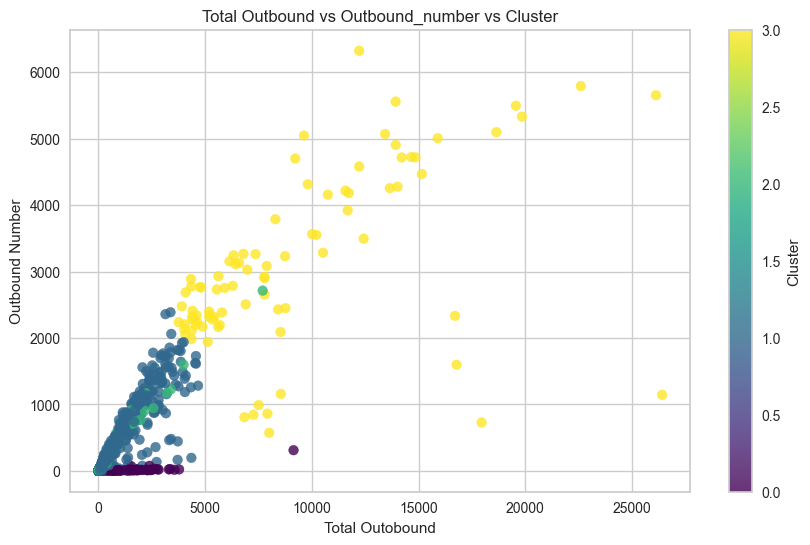

In [23]:
# Visualize scatterplot with total outbound and outbound number
plt.figure(figsize=(10, 6))
plt.scatter(data["total_outbound"], data["outbound_number"], c=data["cluster"], cmap='viridis', alpha=0.8)
plt.title('Total Outbound vs Outbound_number vs Cluster')
plt.xlabel('Total Outobound')
plt.ylabel('Outbound Number')
plt.colorbar(label='Cluster')
plt.show()

With the help of Total outbound and number of outbound plot we can group the product into two categories 
* Products with total outbound>2000 and number of outbound > 8000. (Basically Cluster 3 with yellow)
* Products with total outbound<2000 and number of outbound < 8000. (rest of the clusters) 

The inventory storage for different products can be managed based in this criteria.
This particular categorization is independent of Unit Price of the product.

### Product vs Expire Date vs Cluster

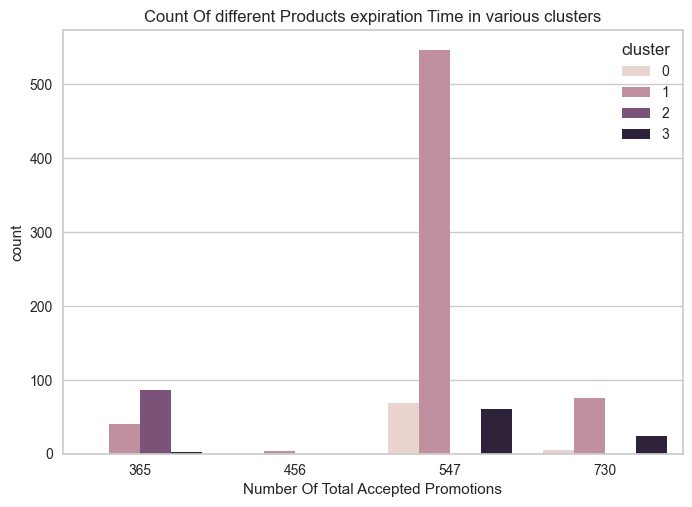

In [24]:
# Visualize countplot on expire date and cluster 
plt.figure()
pl = sns.countplot(x=data["expire_date"], hue=data["cluster"])
pl.set_title("Count Of different Products expiration Time in various clusters")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

* In above countplot, we can clearly see that alot of products lie in the 547 days time period of expiration.
* Products with lesser expiration time such as 365 days can be kept in smaller quantity as compared to products with higher expiration time making more storage area for these products.
* Further grouping into clusters shows that cluster 2 with 547 days expiration can be given priority over other products. However this is not a guarantee that these products are high in outbound. Coupling them with Total outbound order will give a clear idea.

### Various Features compared to Clusters

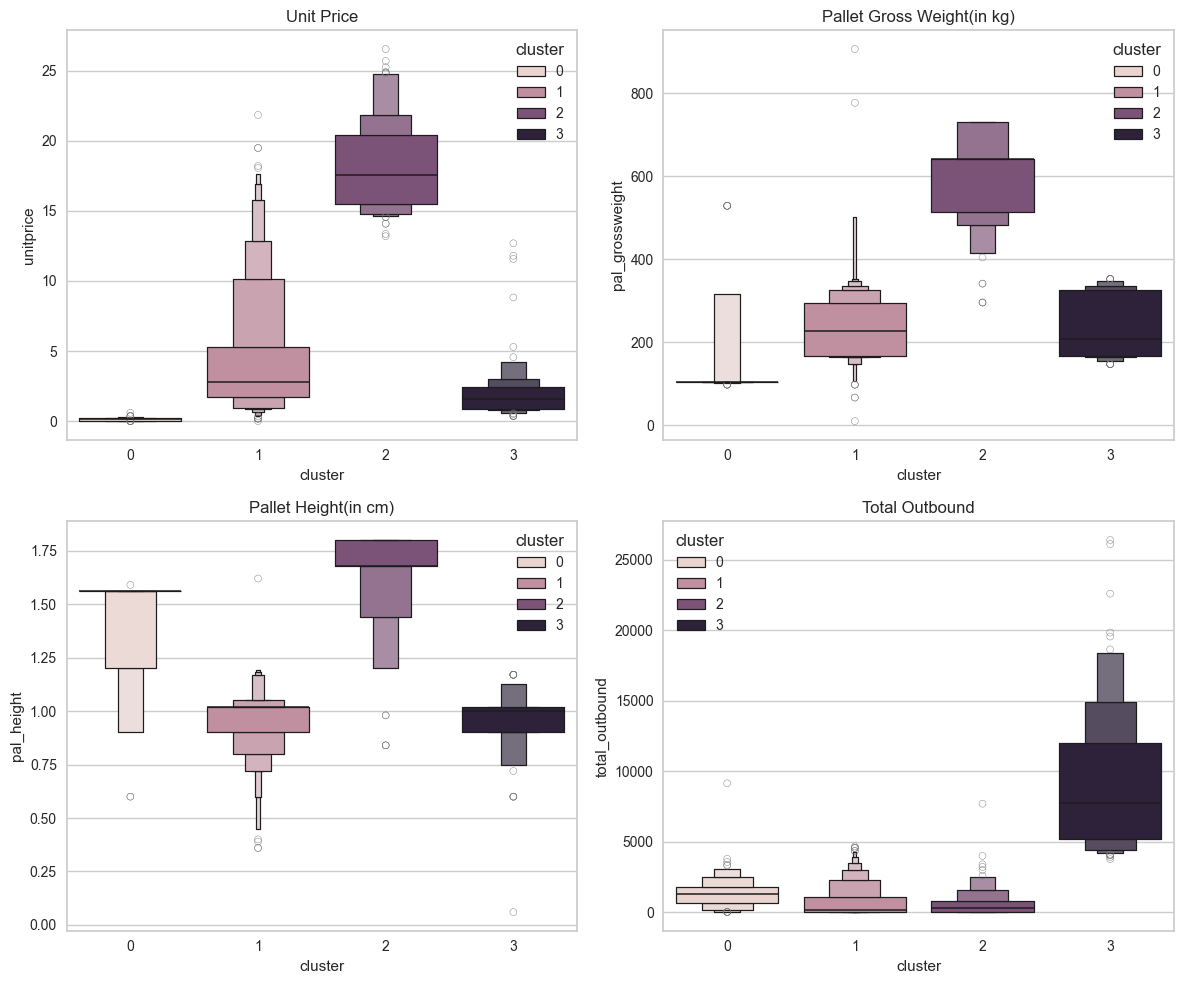

In [25]:

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Creating a 2x2 grid of subplots

# Plot 1
sns.boxenplot(x=data["cluster"], y=data["unitprice"], hue=data["cluster"], ax=axs[0, 0])
axs[0, 0].set_title('Unit Price')

# Plot 2
sns.boxenplot(x=data["cluster"], y=data["pal_grossweight"], hue=data["cluster"], ax=axs[0, 1])
axs[0, 1].set_title('Pallet Gross Weight(in kg)')

# Plot 3
sns.boxenplot(x=data["cluster"], y=data["pal_height"], hue=data["cluster"], ax=axs[1, 0])
axs[1, 0].set_title('Pallet Height(in cm)')

# Plot 4
sns.boxenplot(x=data["cluster"], y=data["total_outbound"], hue=data["cluster"], ax=axs[1, 1])
axs[1, 1].set_title('Total Outbound')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

* Cluster 0 (Beige):
This cluster represents a diverse group of products or items.
    - Unit Price: Within this cluster, you’ll find a wide range of unit prices. Some products are expensive, while others are more affordable.
    - Pallet Gross Weight: The pallets in this cluster vary significantly in weight. Some are heavy, and others are lighter.
    - Pallet Height: The height of pallets in this group also shows variation.
    - Total Outbound: Despite the variability, this cluster contributes significantly to the total outbound items.
* Cluster 1 (Light Purple):
These products or items exhibit more consistency.
    - Unit Price: The unit prices are relatively stable within this cluster.
    - Pallet Gross Weight: Similar to Cluster 0, but with less variation.
    - Pallet Height: Again, consistent heights.
    - Total Outbound: A substantial contribution to the overall outbound count.
* Cluster 2 (Dark Purple):
This cluster represents a specific category or segment.
    - Unit Price: Generally lower unit prices.
    - Pallet Gross Weight: Lighter pallets.
    - Pallet Height: Significant variation in height.
    - Total Outbound: Fewer items leaving compared to other clusters.
* Cluster 3 (Navy Blue):
    - Dominant in terms of volume.
    - Unit Price: Smaller range, possibly mid-range prices.
    - Pallet Gross Weight: Heavier pallets than Cluster 2.
    - Pallet Height: Consistent heights.
    - Total Outbound: Highest contribution to total outbound items. 

## 10. CONCLUSION & FUTURE WORK

Conclusion:
* Best-Selling Products (Clusters 1 & 3): These products, represented by cluster 1 (blue) and cluster 3 (yellow), dominate the market in terms of total orders. Increasing overall inventory for these items is a smart move to meet customer demand.
* Mid-Level Performers: The mid-level performing products (low unit price, moderate orders) fall into cluster 2 (green). While they may not be the top sellers, maintaining a moderate inventory for them ensures a balanced approach.
* Lowest Performing Products (Cluster 2): These products have higher unit prices but fewer orders. Consider reevaluating their pricing or marketing strategies to improve their performance.
* Limited Products (Cluster 0): Although there are fewer products in this category (high unit price and high orders), they significantly contribute to revenue. Keep a close eye on their performance.

* Regarding expiration time:

    - Prioritize products with shorter expiration times (e.g., 365 days) by keeping them in smaller quantities.
    - Cluster 2 (547 days expiration) can be given priority, but coupling this with total outbound orders will provide a clearer picture.

Future Work:
1. * More than half of the data was lost(From 2279 to 911 data points) during pre-processing because of the empty zero values in almost all the columns at some point.
* Resulted in less accurate clustering and loss of values. 
* future scope is to find missing values using [NNI algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) or other algorithm for Imputation.
2. Find out more appropriate value of k for most suitable clustering of data.
3. Improve Variance of PCA from 90% to atleast 95% with n=4


## 11. SOURCE

* https://archive.ics.uci.edu/dataset/531/stock+keeping+units
* https://www.kaggle.com/datark1/code
* https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
* https://scikit-learn.org/stable/modules/clustering.html#clustering


# THANK YOU